In [14]:
# ! pip install seaborn
# ! pip install koreanize-matplotlib

In [16]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [7]:

# 1. 데이터 로드
raw_data = pd.read_csv('raw_data.csv')
match_info = pd.read_csv('match_info.csv')


In [8]:
# 2. 시즌 승점 계산 (팀별 성적 산출)
def get_points(row):
    if row['home_score'] > row['away_score']: return pd.Series([3, 0])
    elif row['home_score'] < row['away_score']: return pd.Series([0, 3])
    else: return pd.Series([1, 1])

match_info[['home_pts', 'away_pts']] = match_info.apply(get_points, axis=1)
home_stats = match_info.groupby('home_team_name_ko')['home_pts'].sum()
away_stats = match_info.groupby('away_team_name_ko')['away_pts'].sum()
season_points = home_stats.add(away_stats, fill_value=0).sort_values(ascending=False)


In [9]:

# 3. 0:0 구간(선제골 전) 데이터 필터링 로직
# 각 경기별 첫 골 시점을 찾음
goals = raw_data[(raw_data['type_name'] == 'Shot') & (raw_data['result_name'] == 'Goal')]
first_goals = goals.sort_values(['game_id', 'period_id', 'time_seconds']).groupby('game_id').first().reset_index()
first_goal_times = first_goals[['game_id', 'period_id', 'time_seconds']]
first_goal_times.columns = ['game_id', 'goal_period', 'goal_time']

# 원본 데이터와 결합하여 0:0 상황만 남김
df = pd.merge(raw_data, first_goal_times, on='game_id', how='left')
df_00 = df[
    df['goal_period'].isna() | # 무득점 경기는 전체 포함
    (df['period_id'] < df['goal_period']) | 
    ((df['period_id'] == df['goal_period']) & (df['time_seconds'] < df['goal_time']))
].copy()


In [10]:
# 4. 역동성(Dynamicism) 지표 계산
# 선수들 위치의 표준편차(std)를 활용하여 '대형의 유연함/활동량'을 측정
def calculate_dynamicism(group):
    coords = group[['start_x', 'start_y']].dropna()
    if len(coords) < 10: return None
    std_x = coords['start_x'].std()
    std_y = coords['start_y'].std()
    # X, Y축 움직임의 크기를 벡터 합으로 통합
    return np.sqrt(std_x**2 + std_y**2)

# 팀별/경기별 역동성 계산 후 시즌 평균 산출
team_dynamicism = df_00.groupby(['team_name_ko', 'game_id']).apply(calculate_dynamicism).groupby('team_name_ko').mean()


C:\Users\user\AppData\Local\Temp\ipykernel_6688\2964538637.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_dynamicism = df_00.groupby(['team_name_ko', 'game_id']).apply(calculate_dynamicism).groupby('team_name_ko').mean()


In [11]:
# 5. 순위 비교 데이터프레임 생성
comparison = pd.DataFrame({
    '승점': season_points,
    '역동성_지표': team_dynamicism
}).dropna()

comparison['승점_순위'] = comparison['승점'].rank(ascending=False, method='min')
comparison['역동성_순위'] = comparison['역동성_지표'].rank(ascending=False, method='min')

# 결과 출력
print("--- 시즌 전체 역동성 vs 승점 순위 비교 ---")
print(comparison.sort_values('역동성_순위'))


--- 시즌 전체 역동성 vs 승점 순위 비교 ---
             승점     역동성_지표  승점_순위  역동성_순위
대구FC         38  31.715297    9.0     1.0
제주SK FC      41  31.572381    8.0     2.0
김천 상무 프로축구단  56  31.135899    2.0     3.0
수원FC         49  31.062752    6.0     4.0
전북 현대 모터스    37  30.963188   10.0     5.0
인천 유나이티드     32  30.749662   12.0     6.0
포항 스틸러스      51  30.615469    4.0     7.0
강원FC         55  30.540089    3.0     8.0
울산 HD FC     61  30.460090    1.0     9.0
대전 하나 시티즌    35  30.400277   11.0    10.0
FC서울         50  30.287857    5.0    11.0
광주FC         43  29.303148    7.0    12.0


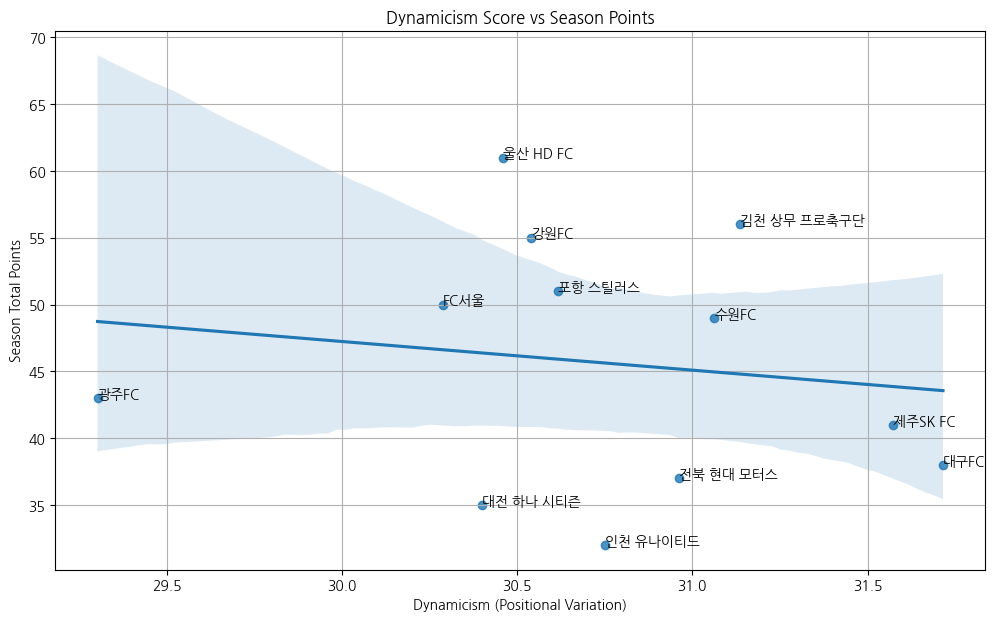

In [17]:

# 6. 시각화 (선택 사항)
plt.figure(figsize=(12, 7))
sns.regplot(data=comparison, x='역동성_지표', y='승점')
for i, txt in enumerate(comparison.index):
    plt.annotate(txt, (comparison['역동성_지표'].iloc[i], comparison['승점'].iloc[i]))
plt.title('Dynamicism Score vs Season Points')
plt.xlabel('Dynamicism (Positional Variation)')
plt.ylabel('Season Total Points')
plt.grid(True)
plt.show()

In [20]:
# 3. 경기별 선제골 시점 및 팀 특정
# Shot 중 Goal인 첫 번째 이벤트 추출
goals = raw_data[(raw_data['type_name'] == 'Shot') & (raw_data['result_name'] == 'Goal')]
first_goals = goals.sort_values(['game_id', 'period_id', 'time_seconds']).groupby('game_id').first().reset_index()
first_goal_info = first_goals[['game_id', 'period_id', 'time_seconds', 'team_id']]
first_goal_info.columns = ['game_id', 'goal_period', 'goal_time', 'scoring_team_id']

# 4. 0:0 구간 데이터 필터링
# 선제골이 터지기 직전까지의 데이터만 남김
df = pd.merge(raw_data, first_goal_info, on='game_id', how='inner')
df_00 = df[((df['period_id'] < df['goal_period']) | 
            ((df['period_id'] == df['goal_period']) & (df['time_seconds'] < df['goal_time'])))].copy()

In [21]:
# 경기별/팀별로 계산
match_team_dyn = df_00.groupby(['game_id', 'team_id']).apply(calculate_dynamicism).reset_index()
match_team_dyn.columns = ['game_id', 'team_id', 'dynamicism']

# 6. 득점팀 vs 실점팀 비교 데이터 생성
# 각 경기별로 선제골 득점 여부 라벨링
match_team_dyn = pd.merge(match_team_dyn, first_goal_info[['game_id', 'scoring_team_id']], on='game_id', how='left')
match_team_dyn['is_first_scorer'] = (match_team_dyn['team_id'] == match_team_dyn['scoring_team_id']).astype(int)

# Pivot을 통해 한 행에 [경기ID, 실점팀역동성, 득점팀역동성] 구조로 변경
pivot_dyn = match_team_dyn.pivot(index='game_id', columns='is_first_scorer', values='dynamicism').dropna()
pivot_dyn.columns = ['conceded_first_dyn', 'scored_first_dyn']

# 결과 산출: 더 역동적인 팀이 선제골을 넣었는가?
pivot_dyn['more_dynamic_scored_first'] = pivot_dyn['scored_first_dyn'] > pivot_dyn['conceded_first_dyn']
success_rate = pivot_dyn['more_dynamic_scored_first'].mean()

C:\Users\user\AppData\Local\Temp\ipykernel_6688\3007614139.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_team_dyn = df_00.groupby(['game_id', 'team_id']).apply(calculate_dynamicism).reset_index()


총 분석 경기 수: 177
상대보다 더 역동적인 팀이 선제골을 넣은 경기: 103
역동성이 높은 팀의 선제골 적중 확률: 58.19%


C:\Users\user\AppData\Local\Temp\ipykernel_6688\1125432482.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=match_team_dyn, x='is_first_scorer', y='dynamicism', palette='Set2')


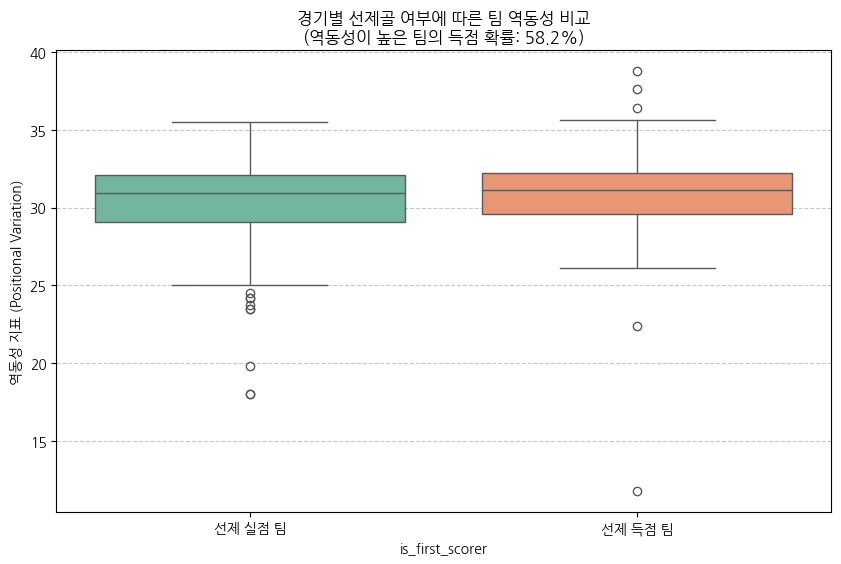

In [22]:
# 7. 시각화 및 결과 출력
print(f"총 분석 경기 수: {len(pivot_dyn)}")
print(f"상대보다 더 역동적인 팀이 선제골을 넣은 경기: {pivot_dyn['more_dynamic_scored_first'].sum()}")
print(f"역동성이 높은 팀의 선제골 적중 확률: {success_rate:.2%}")

plt.figure(figsize=(10, 6))
sns.boxplot(data=match_team_dyn, x='is_first_scorer', y='dynamicism', palette='Set2')
plt.xticks([0, 1], ['선제 실점 팀', '선제 득점 팀'])
plt.title(f'경기별 선제골 여부에 따른 팀 역동성 비교\n(역동성이 높은 팀의 득점 확률: {success_rate:.1%})')
plt.ylabel('역동성 지표 (Positional Variation)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()